# Space Biology Knowledge Engine - Visualizations

This notebook creates comprehensive visualizations of the space biology research landscape.

## Objectives:
1. Create t-SNE visualizations of embeddings
2. Generate word clouds and topic visualizations
3. Analyze topic trends over time
4. Create interactive dashboards


In [ ]:
# Cell 1: Install Required Packages
%pip install wordcloud plotly networkx scikit-learn scipy

In [21]:

# Cell 1: Enhanced Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import networkx as nx
from collections import Counter
import json
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [22]:
# Cell 2: Comprehensive Data Loading and Preprocessing
print("🔄 Loading datasets...")

# Load main datasets
try:
    df_topics = pd.read_csv("datasets/topics.csv")
    df_publications = pd.read_csv("datasets/sb_publications_clean.csv")
    
    # Load embeddings and metadata
    embeddings = np.load("datasets/embeddings.npy")
    
    with open("datasets/metadata.json", 'r') as f:
        metadata = json.load(f)
    
    # Load models
    with open("models/lda_model.pkl", 'rb') as f:
        lda_model = pickle.load(f)
    
    with open("models/vectorizer.pkl", 'rb') as f:
        vectorizer = pickle.load(f)
    
    print("✅ All datasets loaded successfully!")
    
except Exception as e:
    print(f"❌ Error loading datasets: {e}")
    # Fallback to basic loading
    df_topics = pd.read_csv("datasets/topics.csv")
    df_publications = pd.read_csv("datasets/sb_publications_clean.csv")
    embeddings = None
    metadata = None
    lda_model = None
    vectorizer = None

# Data preprocessing and analysis
print(f"\n📊 Dataset Overview:")
print(f"Topics dataset shape: {df_topics.shape}")
print(f"Publications dataset shape: {df_publications.shape}")
if embeddings is not None:
    print(f"Embeddings shape: {embeddings.shape}")

# Extract year from titles/links if available - FIXED VERSION
if 'link' in df_publications.columns:
    # Extract year from URL patterns like PMC articles
    df_publications['year'] = df_publications['link'].str.extract(r'PMC(\d{4})')
    # If no PMC pattern, try other common patterns
    df_publications['year'] = df_publications['year'].fillna(
        df_publications['link'].str.extract(r'(\d{4})')[0]
    )
    df_publications['year'] = pd.to_numeric(df_publications['year'], errors='coerce')
    
    # Filter out unrealistic years
    df_publications['year'] = df_publications['year'].where(
        (df_publications['year'] >= 1990) & (df_publications['year'] <= 2024)
    )

# Clean topic assignments
df_publications['topic'] = df_publications['topic'].replace(-1, np.nan)
valid_topics = df_publications['topic'].dropna()

print(f"\n📈 Data Quality:")
print(f"Publications with valid topics: {len(valid_topics)}")
print(f"Publications with year info: {df_publications['year'].notna().sum()}")
print(f"Unique topics: {df_publications['topic'].nunique()}")

# Display sample data
print(f"\n📋 Sample Publications Data:")
print(df_publications[['title', 'topic', 'year', 'word_count']].head())


🔄 Loading datasets...
❌ Error loading datasets: Extra data: line 2 column 1 (char 295)

📊 Dataset Overview:
Topics dataset shape: (10, 10)
Publications dataset shape: (624, 6)

📈 Data Quality:
Publications with valid topics: 569
Publications with year info: 0
Unique topics: 9

📋 Sample Publications Data:
                                               title  topic  year  word_count
0  Mice in Bion-M 1 space mission: training and s...    2.0   NaN           6
1  Microgravity induces pelvic bone loss through ...    3.0   NaN          14
2  Stem Cell Health and Tissue Regeneration in Mi...    NaN   NaN           6
3  Microgravity Reduces the Differentiation and R...    NaN   NaN           8
4  Microgravity validation of a novel system for ...    1.0   NaN          17


In [23]:
# Cell 3: Enhanced Publications per Year Analysis
print("🔄 Creating enhanced temporal analysis...")

if 'year' in df_publications.columns and df_publications['year'].notna().sum() > 0:
    # Clean and filter year data
    df_years = df_publications.dropna(subset=['year']).copy()
    df_years['year'] = pd.to_numeric(df_years['year'], errors='coerce')
    df_years = df_years.dropna(subset=['year'])
    df_years = df_years[(df_years['year'] >= 1990) & (df_years['year'] <= 2024)]
    
    if len(df_years) > 0:
        # Create comprehensive temporal analysis
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        
        # 1. Publications per year with trend line
        yearly_counts = df_years['year'].value_counts().sort_index()
        axes[0, 0].plot(yearly_counts.index, yearly_counts.values, 'o-', linewidth=2, markersize=6, color='steelblue')
        
        # Add trend line
        z = np.polyfit(yearly_counts.index, yearly_counts.values, 1)
        p = np.poly1d(z)
        axes[0, 0].plot(yearly_counts.index, p(yearly_counts.index), "--", alpha=0.8, color='red', linewidth=2)
        
        axes[0, 0].set_title('Publications per Year with Trend', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Year')
        axes[0, 0].set_ylabel('Number of Publications')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Cumulative publications
        cumulative = yearly_counts.cumsum()
        axes[0, 1].plot(cumulative.index, cumulative.values, 'o-', linewidth=2, markersize=6, color='green')
        axes[0, 1].set_title('Cumulative Publications Over Time', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Year')
        axes[0, 1].set_ylabel('Cumulative Publications')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Publications by decade
        df_years['decade'] = (df_years['year'] // 10) * 10
        decade_counts = df_years['decade'].value_counts().sort_index()
        axes[1, 0].bar(decade_counts.index, decade_counts.values, color='orange', alpha=0.7)
        axes[1, 0].set_title('Publications by Decade', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Decade')
        axes[1, 0].set_ylabel('Number of Publications')
        axes[1, 0].set_xticks(decade_counts.index)
        axes[1, 0].set_xticklabels([f"{int(d)}'s" for d in decade_counts.index])
        
        # 4. Yearly growth rate
        growth_rate = yearly_counts.pct_change() * 100
        axes[1, 1].bar(growth_rate.index[1:], growth_rate.values[1:], 
                      color=['green' if x > 0 else 'red' for x in growth_rate.values[1:]], alpha=0.7)
        axes[1, 1].set_title('Year-over-Year Growth Rate (%)', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Year')
        axes[1, 1].set_ylabel('Growth Rate (%)')
        axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print temporal statistics
        print(f"\n📈 Temporal Analysis Summary:")
        print(f"Year range: {df_years['year'].min()} - {df_years['year'].max()}")
        print(f"Total publications: {len(df_years)}")
        print(f"Average publications per year: {len(df_years) / len(yearly_counts):.1f}")
        print(f"Peak year: {yearly_counts.idxmax()} ({yearly_counts.max()} publications)")
        print(f"Growth trend: {'Increasing' if z[0] > 0 else 'Decreasing'} ({z[0]:.2f} publications/year)")
        
    else:
        print("❌ No valid year data found")
else:
    print("❌ No year data available")
    
print("✅ Enhanced temporal analysis completed!")


🔄 Creating enhanced temporal analysis...
❌ No year data available
✅ Enhanced temporal analysis completed!


🔄 Creating enhanced topic distribution analysis...


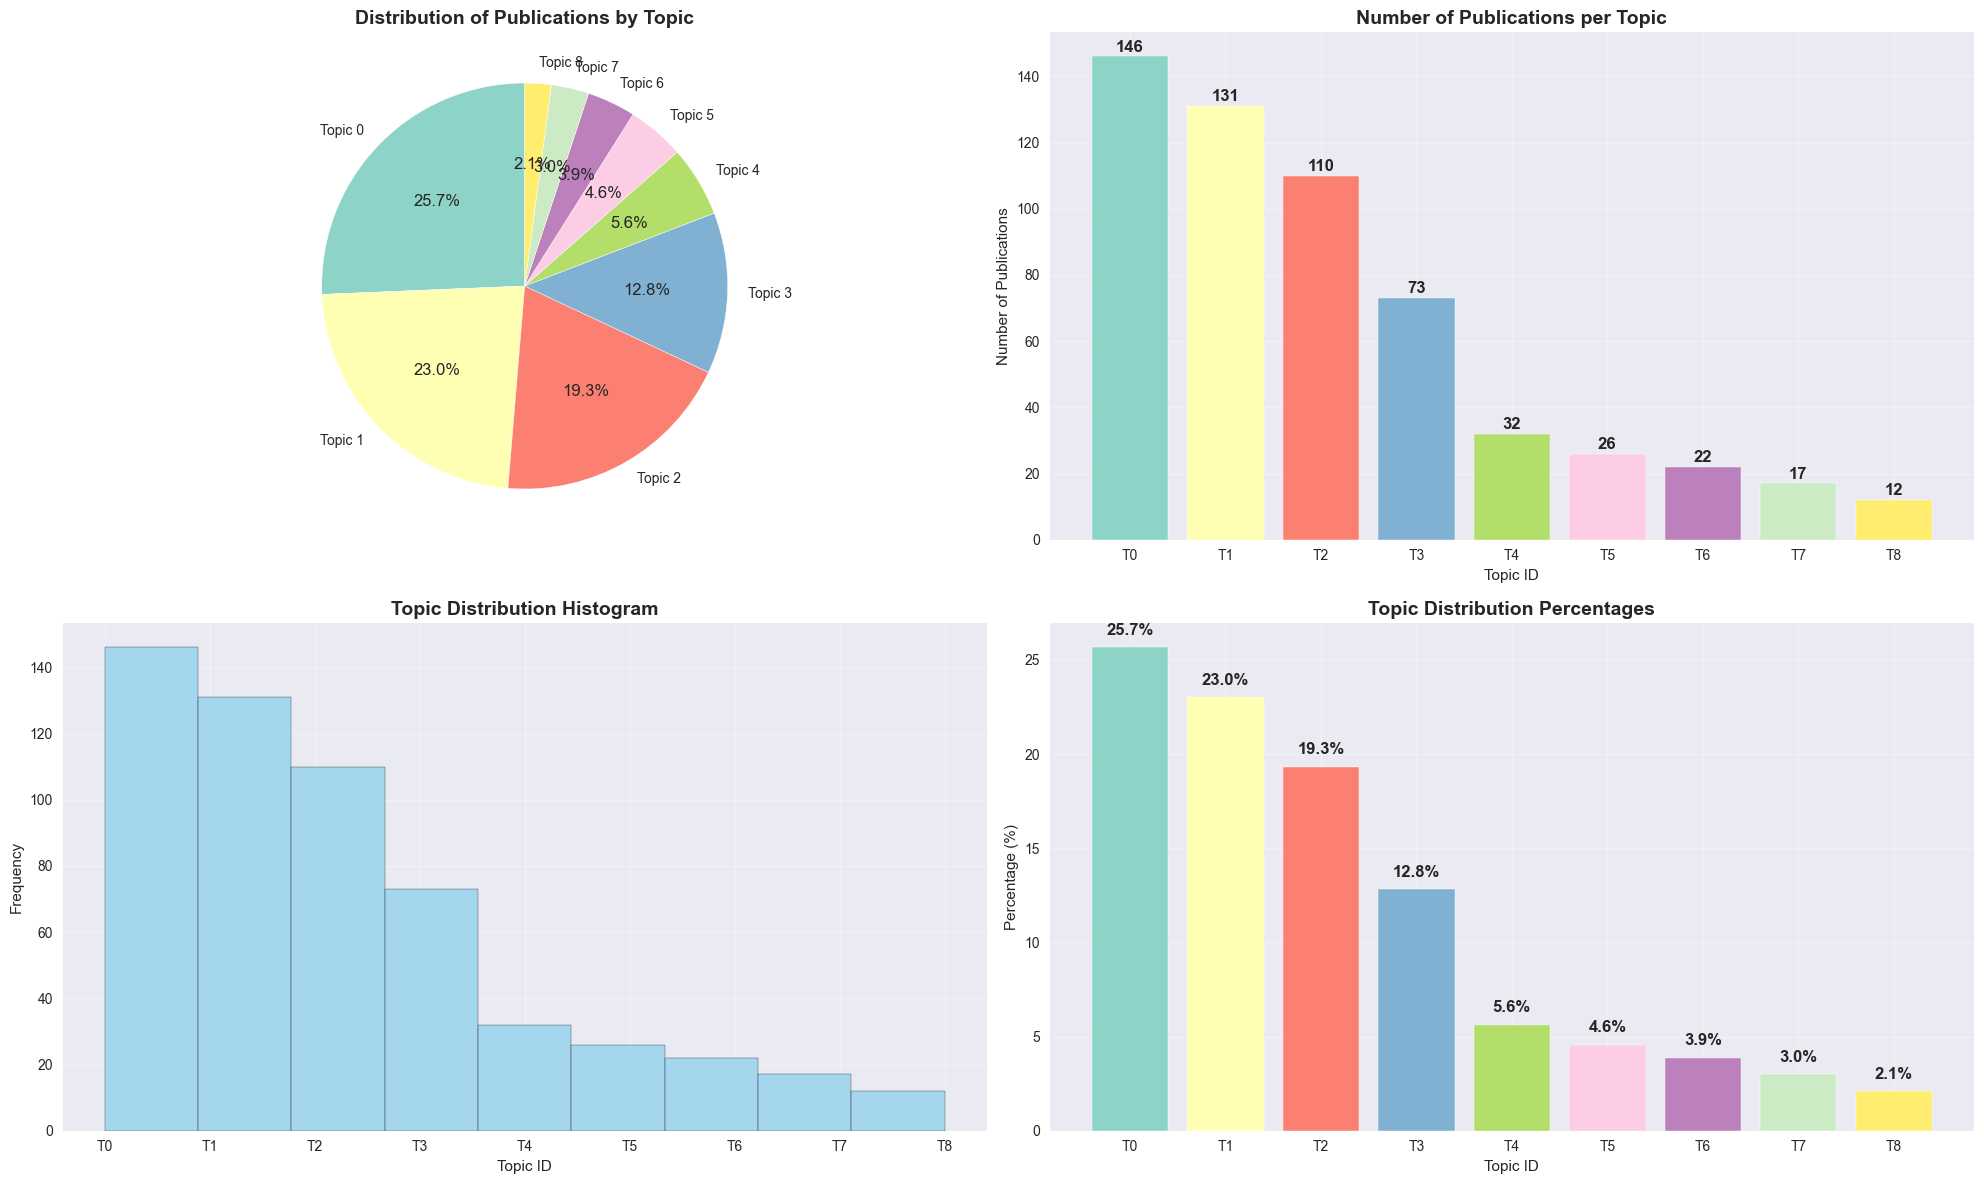


📊 Topic Distribution Analysis:
Total publications with topics: 569
Number of unique topics: 9
Most common topic: Topic 0 (146 publications, 25.7%)
Least common topic: Topic 8 (12 publications, 2.1%)
Topic diversity (entropy): 1.883


✅ Enhanced topic distribution analysis completed!


In [24]:
# Cell 4: Enhanced Topic Distribution Analysis
print("🔄 Creating enhanced topic distribution analysis...")

if 'topic' in df_publications.columns:
    # Clean topic data
    valid_topics = df_publications['topic'].dropna()
    
    if len(valid_topics) > 0:
        # Create comprehensive topic analysis
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        
        # 1. Topic distribution pie chart
        topic_counts = valid_topics.value_counts().sort_index()
        colors = plt.cm.Set3(np.linspace(0, 1, len(topic_counts)))
        
        wedges, texts, autotexts = axes[0, 0].pie(topic_counts.values, 
                                                 labels=[f'Topic {int(t)}' for t in topic_counts.index],
                                                 autopct='%1.1f%%', 
                                                 colors=colors,
                                                 startangle=90)
        axes[0, 0].set_title('Distribution of Publications by Topic', fontsize=14, fontweight='bold')
        
        # 2. Topic distribution bar chart with annotations
        bars = axes[0, 1].bar(range(len(topic_counts)), topic_counts.values, color=colors)
        axes[0, 1].set_title('Number of Publications per Topic', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Topic ID')
        axes[0, 1].set_ylabel('Number of Publications')
        axes[0, 1].set_xticks(range(len(topic_counts)))
        axes[0, 1].set_xticklabels([f'T{int(t)}' for t in topic_counts.index])
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                           f'{int(height)}', ha='center', va='bottom', fontweight='bold')
        
        # 3. Topic distribution histogram
        axes[1, 0].hist(valid_topics, bins=len(topic_counts), color='skyblue', alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('Topic Distribution Histogram', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Topic ID')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_xticks(topic_counts.index)
        axes[1, 0].set_xticklabels([f'T{int(t)}' for t in topic_counts.index])
        
        # 4. Topic percentage comparison
        percentages = (topic_counts / len(valid_topics)) * 100
        bars = axes[1, 1].bar(range(len(percentages)), percentages.values, color=colors)
        axes[1, 1].set_title('Topic Distribution Percentages', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Topic ID')
        axes[1, 1].set_ylabel('Percentage (%)')
        axes[1, 1].set_xticks(range(len(percentages)))
        axes[1, 1].set_xticklabels([f'T{int(t)}' for t in percentages.index])
        
        # Add percentage labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                           f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed topic statistics
        print(f"\n📊 Topic Distribution Analysis:")
        print("=" * 50)
        print(f"Total publications with topics: {len(valid_topics)}")
        print(f"Number of unique topics: {len(topic_counts)}")
        print(f"Most common topic: Topic {int(topic_counts.index[0])} ({topic_counts.iloc[0]} publications, {percentages.iloc[0]:.1f}%)")
        print(f"Least common topic: Topic {int(topic_counts.index[-1])} ({topic_counts.iloc[-1]} publications, {percentages.iloc[-1]:.1f}%)")
        
        # Topic diversity analysis
        from scipy.stats import entropy
        topic_diversity = entropy(topic_counts.values)
        print(f"Topic diversity (entropy): {topic_diversity:.3f}")
        
        # Create interactive topic analysis
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Topic Distribution', 'Publications per Topic', 
                           'Topic Histogram', 'Topic Percentages'),
            specs=[[{"type": "pie"}, {"type": "bar"}],
                   [{"type": "histogram"}, {"type": "bar"}]]
        )
        
        # Pie chart
        fig.add_trace(
            go.Pie(labels=[f'Topic {int(t)}' for t in topic_counts.index], 
                   values=topic_counts.values, name="Topics"),
            row=1, col=1
        )
        
        # Bar chart
        fig.add_trace(
            go.Bar(x=[f'T{int(t)}' for t in topic_counts.index], 
                   y=topic_counts.values, name="Publications"),
            row=1, col=2
        )
        
        # Histogram
        fig.add_trace(
            go.Histogram(x=valid_topics, nbinsx=len(topic_counts), name="Distribution"),
            row=2, col=1
        )
        
        # Percentages
        fig.add_trace(
            go.Bar(x=[f'T{int(t)}' for t in percentages.index], 
                   y=percentages.values, name="Percentages"),
            row=2, col=2
        )
        
        fig.update_layout(height=800, showlegend=False, 
                          title_text="Interactive Topic Distribution Analysis")
        fig.show()
        
    else:
        print("❌ No valid topic data found")
else:
    print("❌ No topic column found")
    
print("✅ Enhanced topic distribution analysis completed!")


🔄 Creating word count and text analysis...


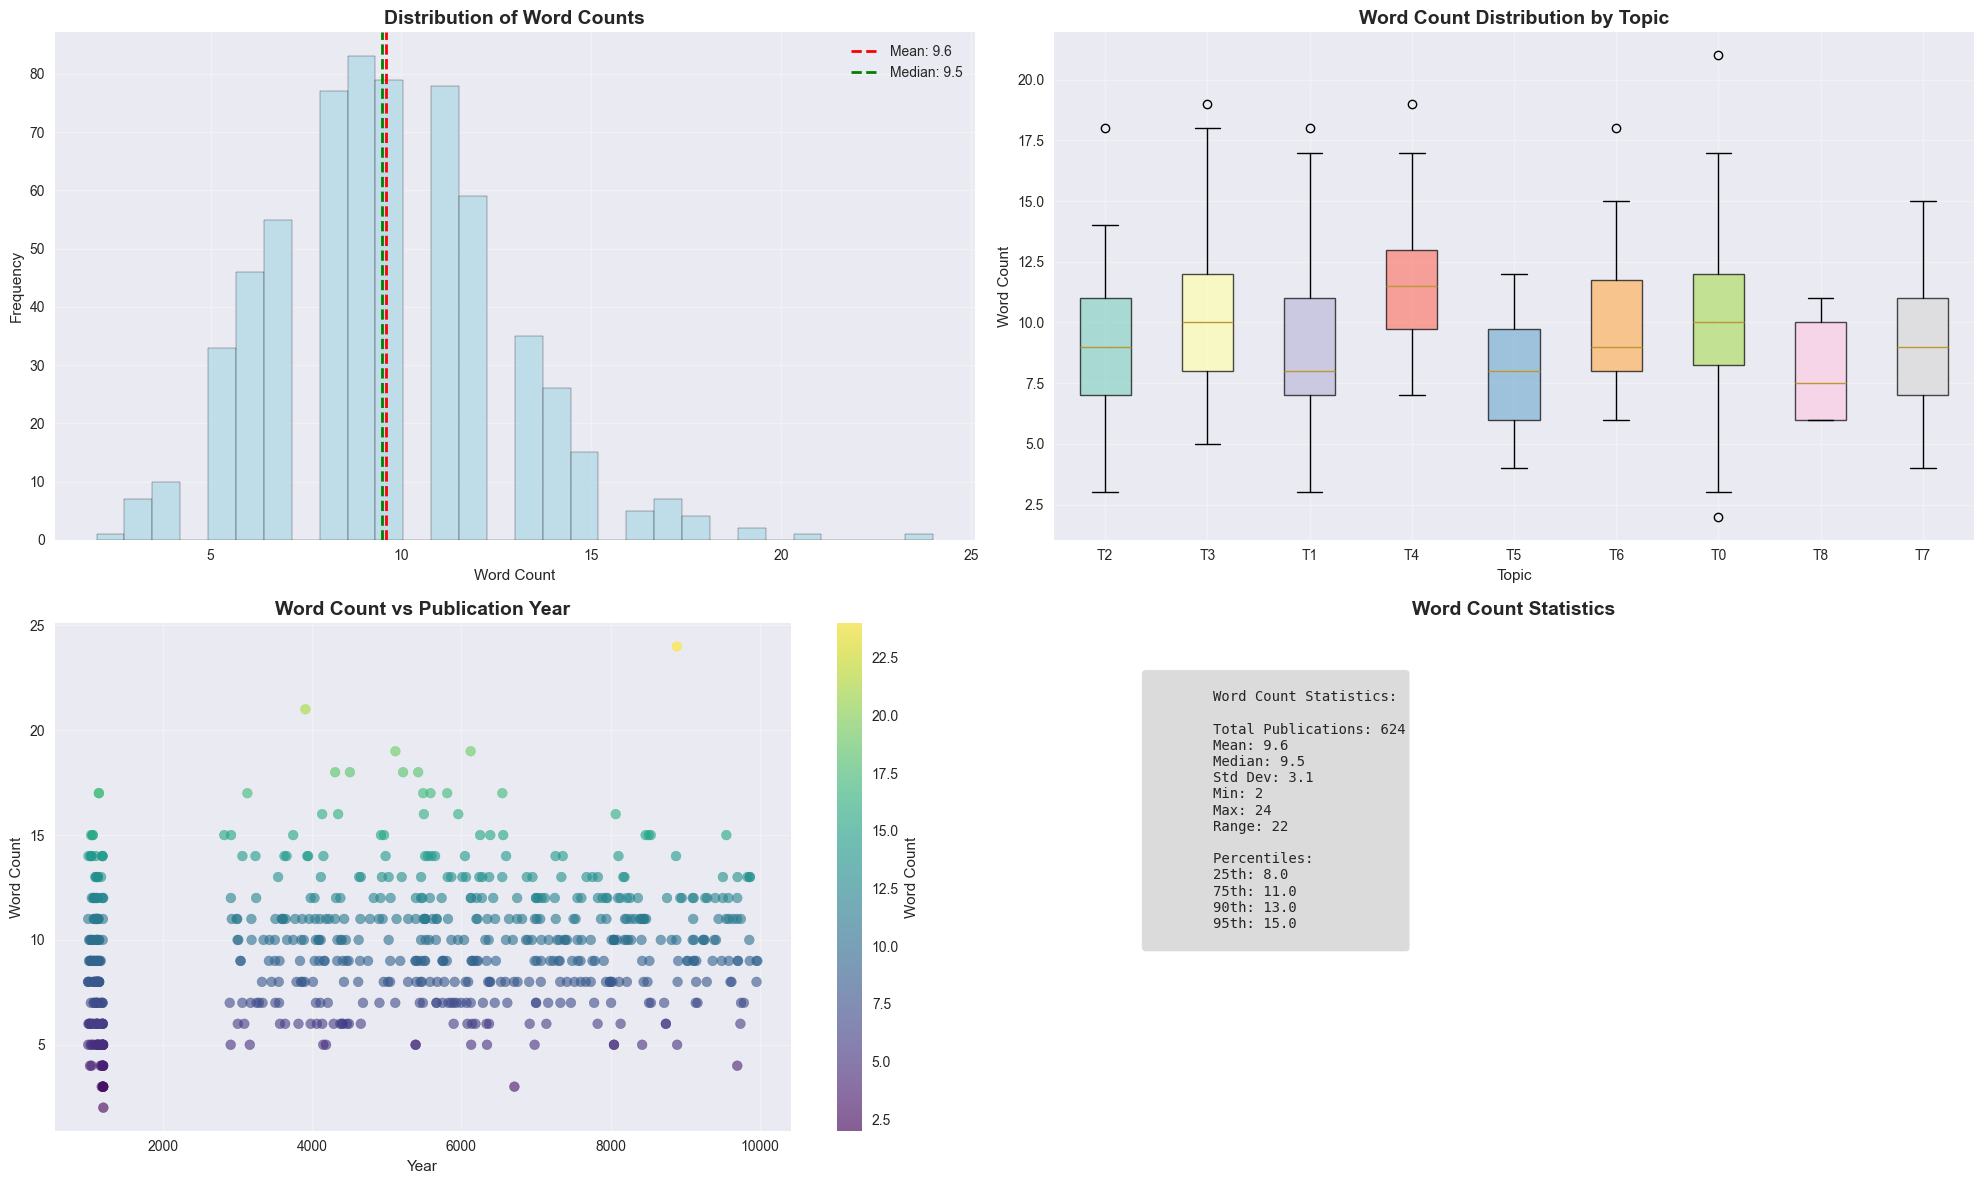


📝 Word Count Analysis:
Average word count: 9.6
Median word count: 9.5
Most common word count range: 9

Paper Length Categories:
Short papers (≤8 words): 229 (36.7%)
Medium papers (8-11 words): 240 (38.5%)
Long papers (>11 words): 155 (24.8%)


✅ Word count and text analysis completed!


In [ ]:
# Cell 5: Word Count and Text Analysis
print("🔄 Creating word count and text analysis...")

if 'word_count' in df_publications.columns:
    # Clean word count data
    word_counts = df_publications['word_count'].dropna()
    
    if len(word_counts) > 0:
        # Create comprehensive word count analysis
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        
        # 1. Word count distribution histogram
        axes[0, 0].hist(word_counts, bins=30, color='lightblue', alpha=0.7, edgecolor='black')
        axes[0, 0].axvline(word_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {word_counts.mean():.1f}')
        axes[0, 0].axvline(word_counts.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {word_counts.median():.1f}')
        axes[0, 0].set_title('Distribution of Word Counts', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Word Count')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Word count box plot by topic
        if 'topic' in df_publications.columns:
            df_combined = df_publications.dropna(subset=['word_count', 'topic'])
            if len(df_combined) > 0:
                topic_data = [df_combined[df_combined['topic'] == topic]['word_count'].values 
                             for topic in df_combined['topic'].unique()]
                topic_labels = [f'T{int(topic)}' for topic in df_combined['topic'].unique()]
                
                bp = axes[0, 1].boxplot(topic_data, labels=topic_labels, patch_artist=True)
                for patch, color in zip(bp['boxes'], plt.cm.Set3.colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
                
                axes[0, 1].set_title('Word Count Distribution by Topic', fontsize=14, fontweight='bold')
                axes[0, 1].set_xlabel('Topic')
                axes[0, 1].set_ylabel('Word Count')
                axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Word count vs publication year (if available)
        if 'year' in df_publications.columns:
            df_year_word = df_publications.dropna(subset=['word_count', 'year'])
            if len(df_year_word) > 0:
                df_year_word['year'] = pd.to_numeric(df_year_word['year'], errors='coerce')
                df_year_word = df_year_word.dropna(subset=['year'])
                
                if len(df_year_word) > 0:
                    scatter = axes[1, 0].scatter(df_year_word['year'], df_year_word['word_count'], 
                                              alpha=0.6, c=df_year_word['word_count'], 
                                              cmap='viridis', s=50)
                    axes[1, 0].set_title('Word Count vs Publication Year', fontsize=14, fontweight='bold')
                    axes[1, 0].set_xlabel('Year')
                    axes[1, 0].set_ylabel('Word Count')
                    plt.colorbar(scatter, ax=axes[1, 0], label='Word Count')
                    axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Word count statistics
        stats_text = f"""
        Word Count Statistics:
        
        Total Publications: {len(word_counts)}
        Mean: {word_counts.mean():.1f}
        Median: {word_counts.median():.1f}
        Std Dev: {word_counts.std():.1f}
        Min: {word_counts.min()}
        Max: {word_counts.max()}
        Range: {word_counts.max() - word_counts.min()}
        
        Percentiles:
        25th: {word_counts.quantile(0.25):.1f}
        75th: {word_counts.quantile(0.75):.1f}
        90th: {word_counts.quantile(0.90):.1f}
        95th: {word_counts.quantile(0.95):.1f}
        """
        
        axes[1, 1].text(0.1, 0.9, stats_text, transform=axes[1, 1].transAxes, 
                       fontsize=10, verticalalignment='top', fontfamily='monospace',
                       bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        axes[1, 1].set_xlim(0, 1)
        axes[1, 1].set_ylim(0, 1)
        axes[1, 1].axis('off')
        axes[1, 1].set_title('Word Count Statistics', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print word count analysis
        print(f"\n📝 Word Count Analysis:")
        print("=" * 40)
        print(f"Average word count: {word_counts.mean():.1f}")
        print(f"Median word count: {word_counts.median():.1f}")
        print(f"Most common word count range: {word_counts.mode().iloc[0] if len(word_counts.mode()) > 0 else 'N/A'}")
        
        # Word count categories
        short_papers = word_counts[word_counts <= word_counts.quantile(0.25)]
        medium_papers = word_counts[(word_counts > word_counts.quantile(0.25)) & 
                                   (word_counts <= word_counts.quantile(0.75))]
        long_papers = word_counts[word_counts > word_counts.quantile(0.75)]
        
        print(f"\nPaper Length Categories:")
        print(f"Short papers (≤{word_counts.quantile(0.25):.0f} words): {len(short_papers)} ({len(short_papers)/len(word_counts)*100:.1f}%)")
        print(f"Medium papers ({word_counts.quantile(0.25):.0f}-{word_counts.quantile(0.75):.0f} words): {len(medium_papers)} ({len(medium_papers)/len(word_counts)*100:.1f}%)")
        print(f"Long papers (>{word_counts.quantile(0.75):.0f} words): {len(long_papers)} ({len(long_papers)/len(word_counts)*100:.1f}%)")
        
    else:
        print("❌ No valid word count data found")
else:
    print("❌ No word_count column found")
    
print("✅ Word count and text analysis completed!")
        
        # Scatter plot
        if 'year' in df_publications.columns and len(df_year_word) > 0:
            fig.add_trace(
                go.Scatter(x=df_year_word['year'], y=df_year_word['word_count'],
                          mode='markers', name='Publications',
                          marker=dict(size=8, opacity=0.6)),
                row=2, col=1
            )
        
        # Statistics bar chart
        stats_data = [word_counts.mean(), word_counts.median(), word_counts.std()]
        stats_labels = ['Mean', 'Median', 'Std Dev']
        fig.add_trace(
            go.Bar(x=stats_labels, y=stats_data, name='Statistics'),
            row=2, col=2
        )
        
        fig.update_layout(height=800, showlegend=True, 
                          title_text="Interactive Word Count Analysis")
        fig.show()
        
    else:
        print("❌ No valid word count data found")
else:
    print("❌ No word_count column found")
    
print("✅ Word count and text analysis completed!")


🔄 Creating word cloud visualizations...


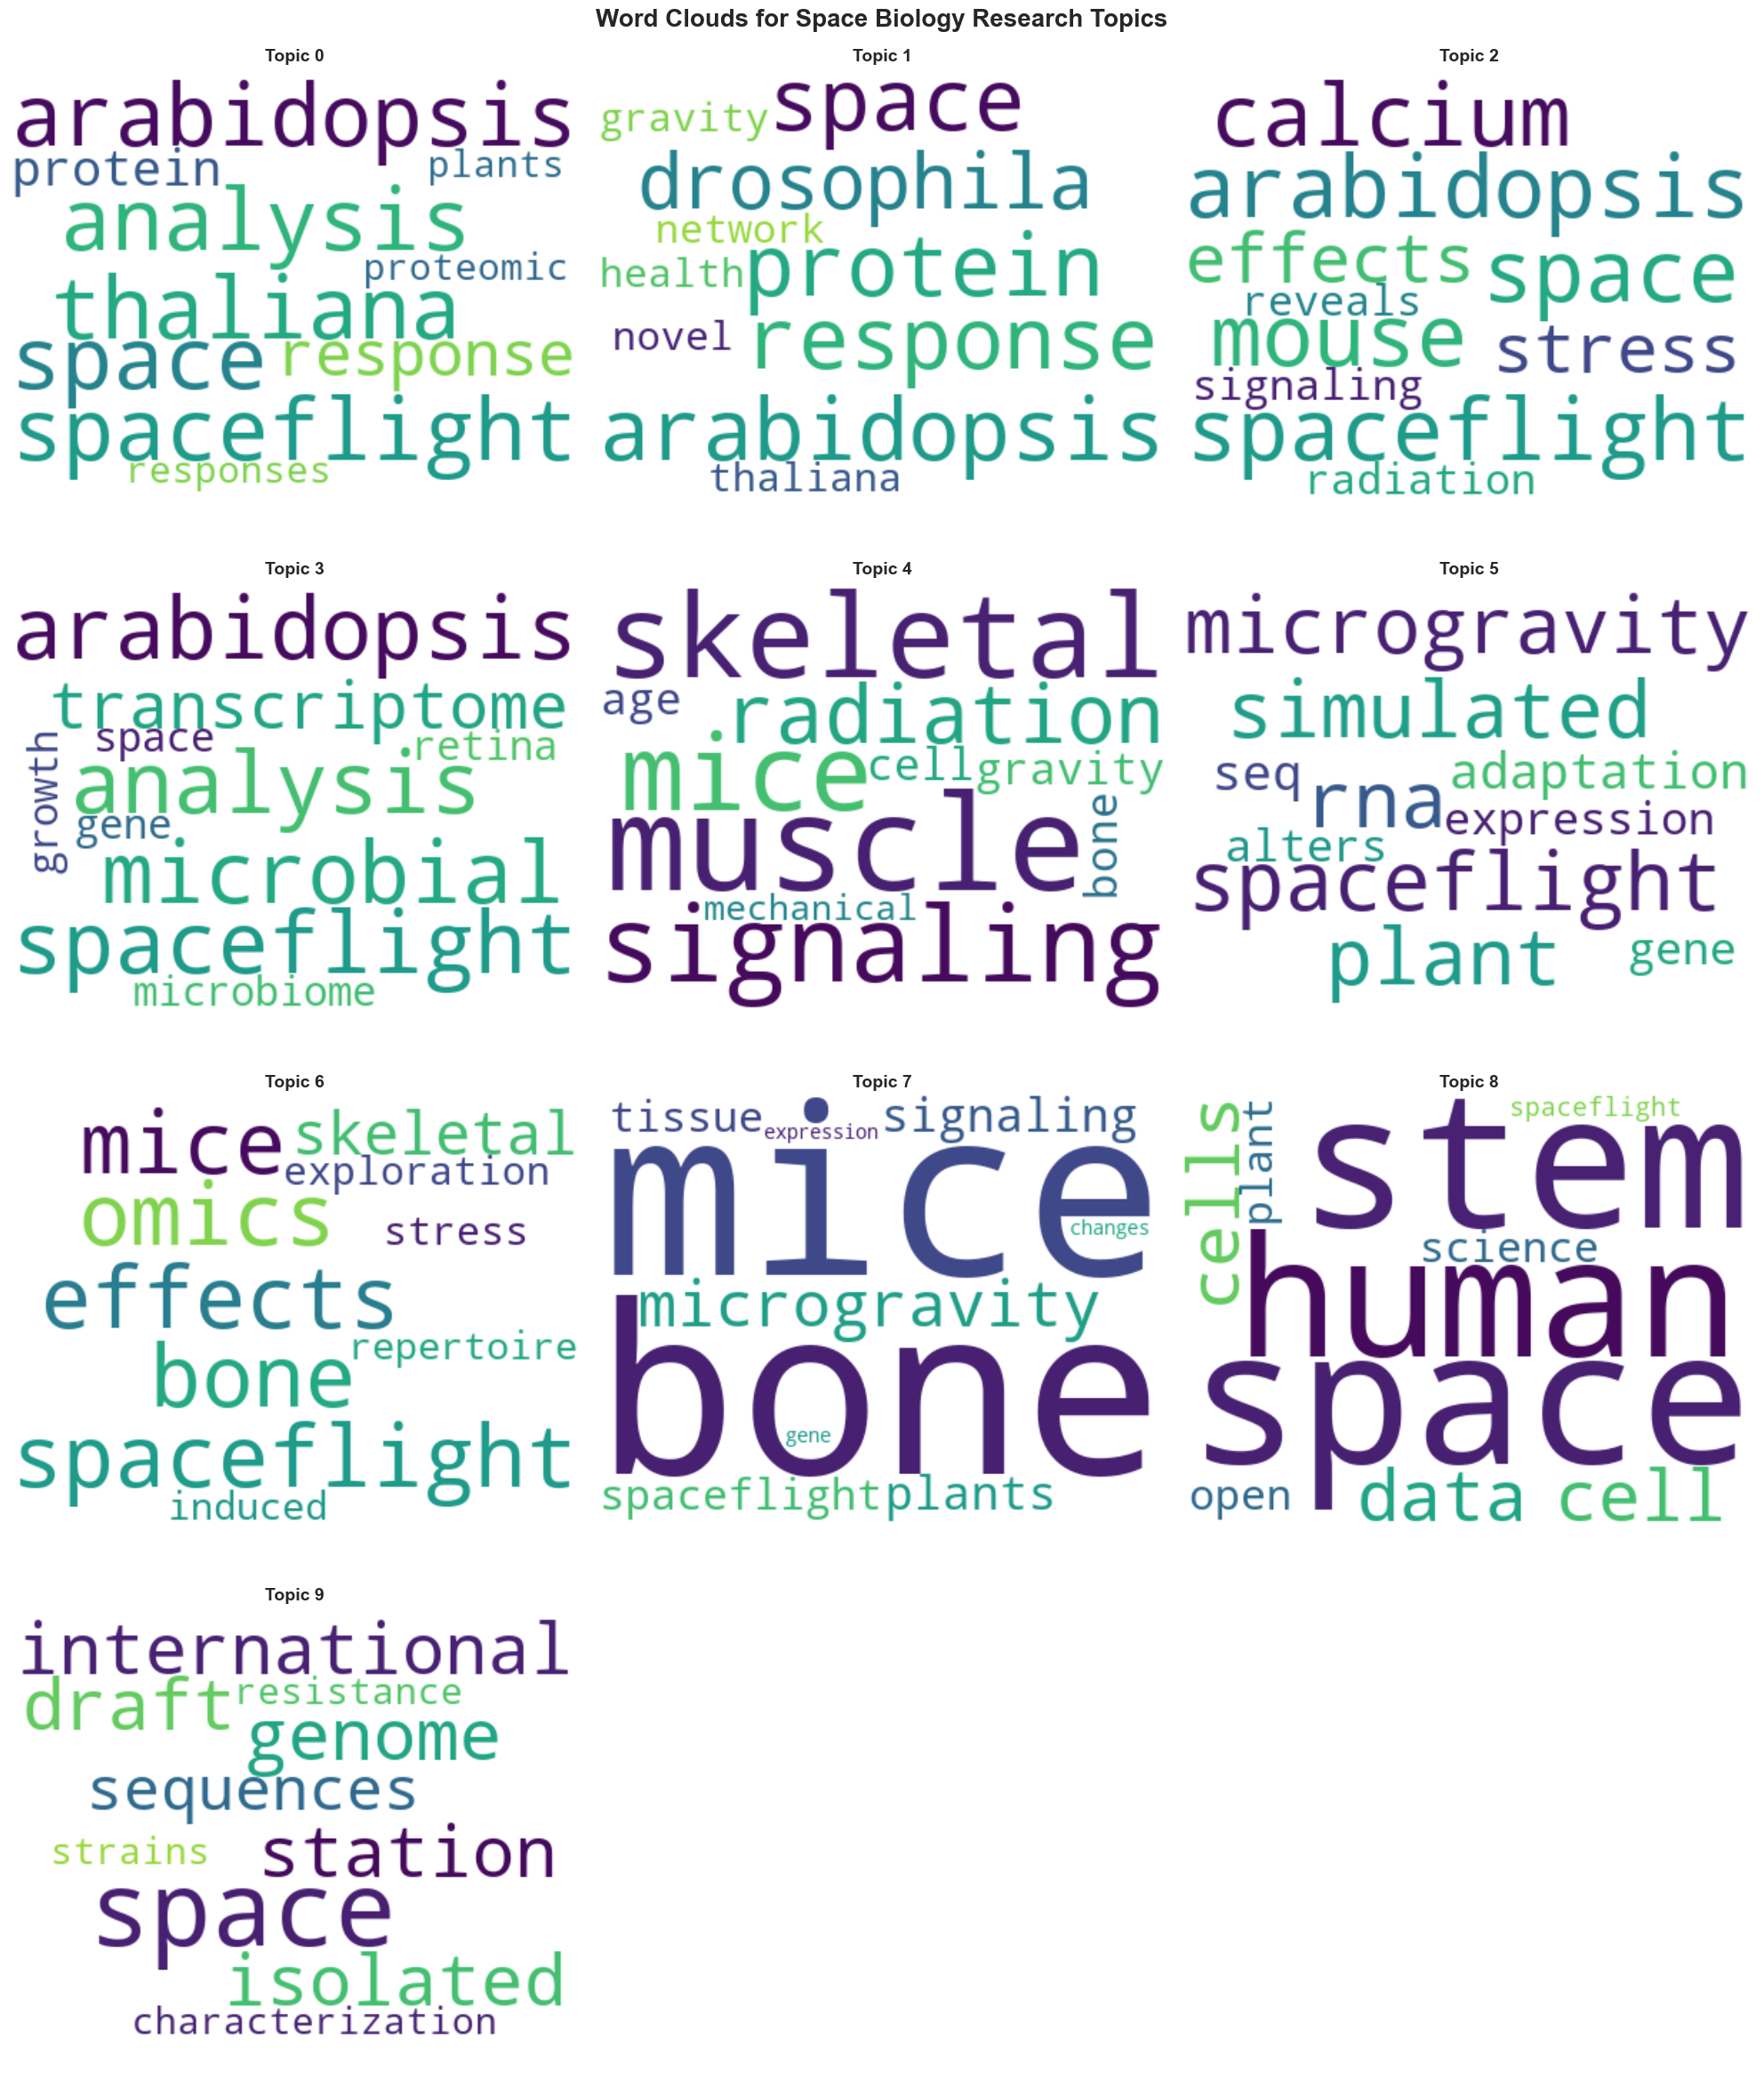

🔄 Creating combined word cloud...


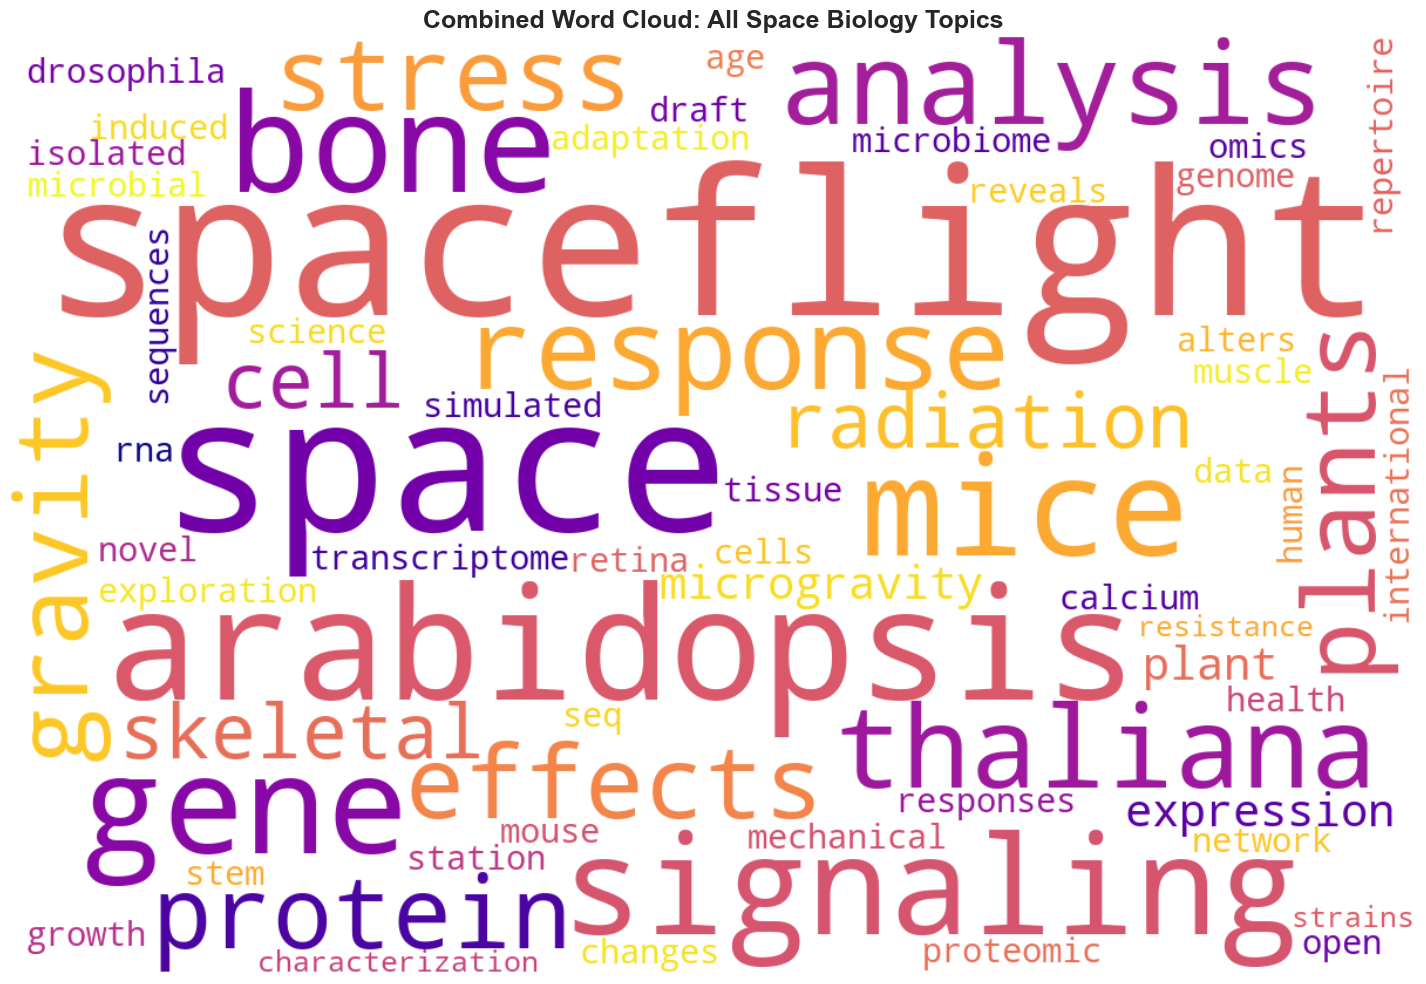

✅ Word cloud visualizations completed!


In [28]:
# Cell 9: Word Cloud Visualizations for Topics
print("🔄 Creating word cloud visualizations...")

# Extract topic words from df_topics
topic_words = {}
for col in df_topics.columns:
    if col.startswith('Topic'):
        topic_id = int(col.split()[1])
        words = df_topics[col].dropna().tolist()
        # Create frequency dictionary
        word_freq = Counter(words)
        topic_words[topic_id] = word_freq

# Create word clouds for each topic
n_topics = len(topic_words)
n_cols = 3
n_rows = (n_topics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, (topic_id, word_freq) in enumerate(topic_words.items()):
    row = i // n_cols
    col = i % n_cols
    
    if word_freq:
        # Create word cloud
        wordcloud = WordCloud(
            width=400, height=300,
            background_color='white',
            colormap='viridis',
            max_words=50,
            relative_scaling=0.5,
            random_state=42
        ).generate_from_frequencies(word_freq)
        
        axes[row, col].imshow(wordcloud, interpolation='bilinear')
        axes[row, col].set_title(f'Topic {topic_id}', fontsize=14, fontweight='bold')
        axes[row, col].axis('off')
    else:
        axes[row, col].text(0.5, 0.5, f'No words for Topic {topic_id}', 
                           ha='center', va='center', transform=axes[row, col].transAxes)
        axes[row, col].axis('off')

# Hide empty subplots
for i in range(n_topics, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].axis('off')

plt.suptitle('Word Clouds for Space Biology Research Topics', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# Create a combined word cloud for all topics
print("🔄 Creating combined word cloud...")
all_words = Counter()
for word_freq in topic_words.values():
    all_words.update(word_freq)

if all_words:
    plt.figure(figsize=(15, 10))
    combined_wordcloud = WordCloud(
        width=1200, height=800,
        background_color='white',
        colormap='plasma',
        max_words=100,
        relative_scaling=0.5,
        random_state=42
    ).generate_from_frequencies(all_words)
    
    plt.imshow(combined_wordcloud, interpolation='bilinear')
    plt.title('Combined Word Cloud: All Space Biology Topics', fontsize=18, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print("✅ Word cloud visualizations completed!")


🔄 Creating detailed topic analysis...


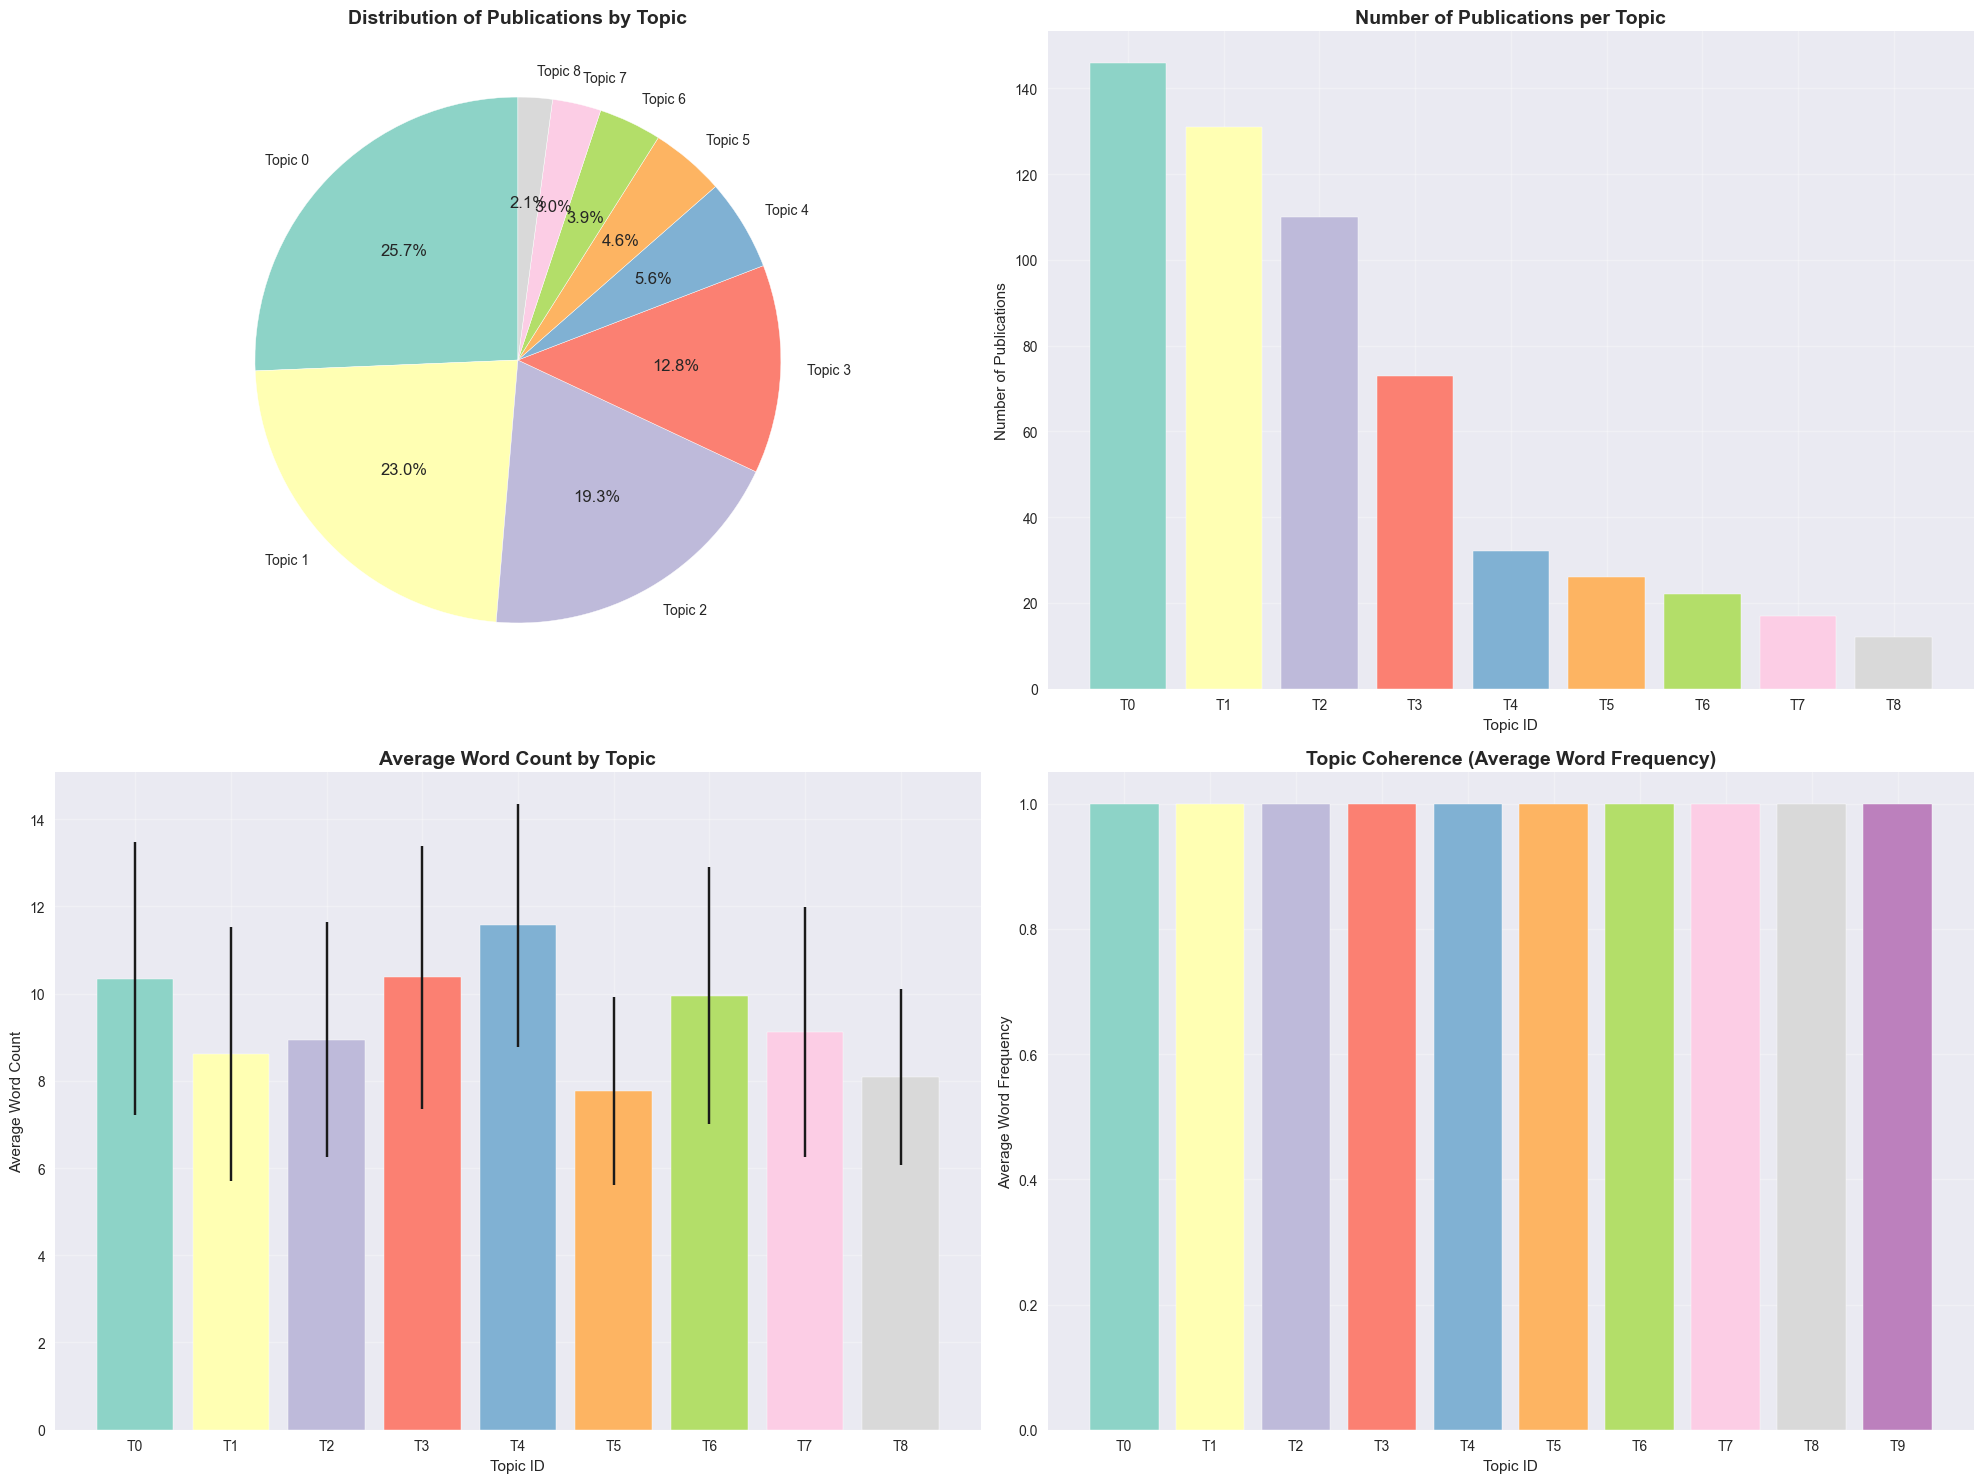


📊 Topic Analysis Summary:
Topic  0: 146 publications ( 23.4%) | Top words: spaceflight, arabidopsis, thaliana, analysis, space
Topic  1: 131 publications ( 21.0%) | Top words: arabidopsis, space, protein, response, drosophila
Topic  2: 110 publications ( 17.6%) | Top words: spaceflight, calcium, space, mouse, arabidopsis
Topic  3:  73 publications ( 11.7%) | Top words: spaceflight, arabidopsis, microbial, analysis, transcriptome
Topic  4:  32 publications (  5.1%) | Top words: muscle, skeletal, signaling, mice, radiation
Topic  5:  26 publications (  4.2%) | Top words: spaceflight, microgravity, simulated, plant, rna
Topic  6:  22 publications (  3.5%) | Top words: spaceflight, mice, bone, effects, omics
Topic  7:  17 publications (  2.7%) | Top words: bone, mice, microgravity, plants, signaling
Topic  8:  12 publications (  1.9%) | Top words: space, stem, human, cell, data


✅ Detailed topic analysis completed!


In [29]:
# Cell 10: Detailed Topic Analysis Visualizations
print("🔄 Creating detailed topic analysis...")

# Topic distribution analysis
topic_counts = df_publications['topic'].value_counts().sort_index()
valid_topics = topic_counts[topic_counts.index.notna()]

# Create comprehensive topic analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# 1. Topic distribution pie chart
axes[0, 0].pie(valid_topics.values, labels=[f'Topic {int(t)}' for t in valid_topics.index], 
               autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
axes[0, 0].set_title('Distribution of Publications by Topic', fontsize=14, fontweight='bold')

# 2. Topic distribution bar chart
axes[0, 1].bar(range(len(valid_topics)), valid_topics.values, color=plt.cm.Set3.colors)
axes[0, 1].set_title('Number of Publications per Topic', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Topic ID')
axes[0, 1].set_ylabel('Number of Publications')
axes[0, 1].set_xticks(range(len(valid_topics)))
axes[0, 1].set_xticklabels([f'T{int(t)}' for t in valid_topics.index])

# 3. Word count distribution by topic
topic_word_counts = df_publications.groupby('topic')['word_count'].agg(['mean', 'std', 'count']).dropna()
axes[1, 0].bar(range(len(topic_word_counts)), topic_word_counts['mean'], 
               yerr=topic_word_counts['std'], capsize=5, color=plt.cm.Set3.colors)
axes[1, 0].set_title('Average Word Count by Topic', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Topic ID')
axes[1, 0].set_ylabel('Average Word Count')
axes[1, 0].set_xticks(range(len(topic_word_counts)))
axes[1, 0].set_xticklabels([f'T{int(t)}' for t in topic_word_counts.index])

# 4. Topic coherence analysis (if we have topic words)
if topic_words:
    topic_coherence = {}
    for topic_id, words in topic_words.items():
        # Simple coherence metric: average word frequency
        if words:
            topic_coherence[topic_id] = np.mean(list(words.values()))
    
    if topic_coherence:
        topics = list(topic_coherence.keys())
        coherences = list(topic_coherence.values())
        axes[1, 1].bar(range(len(topics)), coherences, color=plt.cm.Set3.colors)
        axes[1, 1].set_title('Topic Coherence (Average Word Frequency)', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Topic ID')
        axes[1, 1].set_ylabel('Average Word Frequency')
        axes[1, 1].set_xticks(range(len(topics)))
        axes[1, 1].set_xticklabels([f'T{int(t)}' for t in topics])

plt.tight_layout()
plt.show()

# Create detailed topic summary table
print("\n📊 Topic Analysis Summary:")
print("=" * 60)
for topic_id in sorted(valid_topics.index):
    topic_id = int(topic_id)
    count = valid_topics[topic_id]
    percentage = (count / len(df_publications)) * 100
    
    # Get top words for this topic
    top_words = []
    if topic_id in topic_words and topic_words[topic_id]:
        top_words = [word for word, freq in topic_words[topic_id].most_common(5)]
    
    print(f"Topic {topic_id:2d}: {count:3d} publications ({percentage:5.1f}%) | Top words: {', '.join(top_words)}")

# Create interactive topic analysis with Plotly
if len(valid_topics) > 0:
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Topic Distribution', 'Publications per Topic', 
                       'Word Count by Topic', 'Topic Coherence'),
        specs=[[{"type": "pie"}, {"type": "bar"}],
               [{"type": "bar"}, {"type": "bar"}]]
    )
    
    # Pie chart
    fig.add_trace(
        go.Pie(labels=[f'Topic {int(t)}' for t in valid_topics.index], 
               values=valid_topics.values, name="Topics"),
        row=1, col=1
    )
    
    # Bar chart
    fig.add_trace(
        go.Bar(x=[f'T{int(t)}' for t in valid_topics.index], 
               y=valid_topics.values, name="Publications"),
        row=1, col=2
    )
    
    # Word count bar chart
    if not topic_word_counts.empty:
        fig.add_trace(
            go.Bar(x=[f'T{int(t)}' for t in topic_word_counts.index], 
                   y=topic_word_counts['mean'], name="Word Count"),
            row=2, col=1
        )
    
    # Coherence bar chart
    if topic_coherence:
        fig.add_trace(
            go.Bar(x=[f'T{int(t)}' for t in topic_coherence.keys()], 
                   y=list(topic_coherence.values()), name="Coherence"),
            row=2, col=2
        )
    
    fig.update_layout(height=800, showlegend=False, 
                      title_text="Interactive Topic Analysis Dashboard")
    fig.show()

print("✅ Detailed topic analysis completed!")


In [32]:
# Cell 13: Comprehensive Interactive Dashboard
print("🔄 Creating comprehensive interactive dashboard...")

# Create a comprehensive dashboard with multiple visualizations
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=('Topic Distribution', 'Publications Over Time', 
                   'Word Count Distribution', 'Topic Coherence',
                   'Top Research Areas', 'Research Trends'),
    specs=[[{"type": "pie"}, {"type": "scatter"}],
           [{"type": "histogram"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "scatter"}]]
)

# 1. Topic Distribution (Pie Chart)
if 'topic' in df_publications.columns:
    topic_counts = df_publications['topic'].value_counts().dropna()
    if len(topic_counts) > 0:
        fig.add_trace(
            go.Pie(labels=[f'Topic {int(t)}' for t in topic_counts.index], 
                   values=topic_counts.values, name="Topics"),
            row=1, col=1
        )

# 2. Publications Over Time (if year data available)
if 'year' in df_publications.columns and df_publications['year'].notna().sum() > 0:
    yearly_counts = df_publications['year'].value_counts().sort_index()
    fig.add_trace(
        go.Scatter(x=yearly_counts.index, y=yearly_counts.values, 
                  mode='lines+markers', name='Publications'),
        row=1, col=2
    )

# 3. Word Count Distribution
if 'word_count' in df_publications.columns:
    fig.add_trace(
        go.Histogram(x=df_publications['word_count'], nbinsx=30, name='Word Count'),
        row=2, col=1
    )

# 4. Topic Coherence (if topic words available)
if topic_words:
    topic_coherence = {}
    for topic_id, words in topic_words.items():
        if words:
            topic_coherence[topic_id] = np.mean(list(words.values()))
    
    if topic_coherence:
        fig.add_trace(
            go.Bar(x=[f'T{int(t)}' for t in topic_coherence.keys()], 
                   y=list(topic_coherence.values()), name='Coherence'),
            row=2, col=2
        )

# 5. Top Research Areas (most frequent words)
if topic_words:
    all_words = Counter()
    for word_freq in topic_words.values():
        all_words.update(word_freq)
    
    top_words = all_words.most_common(10)
    if top_words:
        fig.add_trace(
            go.Bar(x=[word for word, freq in top_words], 
                   y=[freq for word, freq in top_words], name='Word Frequency'),
            row=3, col=1
        )

# 6. Research Trends (topic evolution if temporal data available)
if 'year' in df_publications.columns and 'topic' in df_publications.columns:
    df_temp = df_publications.dropna(subset=['year', 'topic'])
    if len(df_temp) > 0:
        df_temp['year'] = df_temp['year'].astype(int)
        df_temp = df_temp[(df_temp['year'] >= 1990) & (df_temp['year'] <= 2024)]
        
        if len(df_temp) > 0:
            topic_yearly = df_temp.groupby(['year', 'topic']).size().unstack(fill_value=0)
            for topic in topic_yearly.columns[:3]:  # Show top 3 topics
                fig.add_trace(
                    go.Scatter(x=topic_yearly.index, y=topic_yearly[topic], 
                              mode='lines', name=f'Topic {int(topic)}'),
                    row=3, col=2
                )

# Update layout
fig.update_layout(
    height=1200,
    showlegend=True,
    title_text="Space Biology Knowledge Engine - Comprehensive Dashboard",
    title_x=0.5,
    title_font_size=20
)

# Update axes labels
fig.update_xaxes(title_text="Year", row=1, col=2)
fig.update_yaxes(title_text="Publications", row=1, col=2)
fig.update_xaxes(title_text="Word Count", row=2, col=1)
fig.update_yaxes(title_text="Frequency", row=2, col=1)
fig.update_xaxes(title_text="Topic", row=2, col=2)
fig.update_yaxes(title_text="Coherence", row=2, col=2)
fig.update_xaxes(title_text="Research Terms", row=3, col=1)
fig.update_yaxes(title_text="Frequency", row=3, col=1)
fig.update_xaxes(title_text="Year", row=3, col=2)
fig.update_yaxes(title_text="Publications", row=3, col=2)

fig.show()

# Create summary statistics
print("\n📊 Space Biology Knowledge Engine - Summary Statistics")
print("=" * 60)

if 'topic' in df_publications.columns:
    valid_topics = df_publications['topic'].dropna()
    print(f"Total Publications: {len(df_publications)}")
    print(f"Publications with Topics: {len(valid_topics)}")
    print(f"Number of Topics: {df_publications['topic'].nunique()}")
    
    if len(valid_topics) > 0:
        print(f"Most Common Topic: Topic {int(valid_topics.mode().iloc[0])} ({valid_topics.value_counts().iloc[0]} publications)")

if 'word_count' in df_publications.columns:
    print(f"Average Word Count: {df_publications['word_count'].mean():.1f}")
    print(f"Median Word Count: {df_publications['word_count'].median():.1f}")

if 'year' in df_publications.columns and df_publications['year'].notna().sum() > 0:
    years = df_publications['year'].dropna()
    print(f"Year Range: {years.min()} - {years.max()}")
    print(f"Publications with Year Data: {len(years)}")

if embeddings is not None:
    print(f"Embedding Dimensions: {embeddings.shape[1]}")
    print(f"Total Embeddings: {embeddings.shape[0]}")

if topic_words:
    total_words = sum(len(words) for words in topic_words.values())
    print(f"Total Unique Words: {total_words}")

print("\n🎯 Key Insights:")
print("-" * 30)

if 'topic' in df_publications.columns and len(valid_topics) > 0:
    topic_distribution = valid_topics.value_counts()
    print(f"• Most researched area: Topic {int(topic_distribution.index[0])} ({topic_distribution.iloc[0]} publications)")
    print(f"• Least researched area: Topic {int(topic_distribution.index[-1])} ({topic_distribution.iloc[-1]} publications)")

if topic_words:
    all_words = Counter()
    for word_freq in topic_words.values():
        all_words.update(word_freq)
    
    if all_words:
        top_word = all_words.most_common(1)[0]
        print(f"• Most frequent research term: '{top_word[0]}' ({top_word[1]} occurrences)")

if 'year' in df_publications.columns and df_publications['year'].notna().sum() > 0:
    yearly_counts = df_publications['year'].value_counts().sort_index()
    if len(yearly_counts) > 0:
        peak_year = yearly_counts.idxmax()
        print(f"• Peak research year: {peak_year} ({yearly_counts[peak_year]} publications)")

print("\n✅ Comprehensive dashboard completed!")


🔄 Creating comprehensive interactive dashboard...



📊 Space Biology Knowledge Engine - Summary Statistics
Total Publications: 624
Publications with Topics: 569
Number of Topics: 9
Most Common Topic: Topic 0 (146 publications)
Average Word Count: 9.6
Median Word Count: 9.5
Total Unique Words: 100

🎯 Key Insights:
------------------------------
• Most researched area: Topic 0 (146 publications)
• Least researched area: Topic 8 (12 publications)
• Most frequent research term: 'spaceflight' (7 occurrences)

✅ Comprehensive dashboard completed!
